# Modules

In [1]:
import math
from torch import set_grad_enabled
from torch import empty
set_grad_enabled(False)

In [2]:
class Module(object):
    """ We followed the recommended structure for a Module given in the project statement.
    """
    
    def forward(self,*input):
        """ forward should get for input, and returns, a tensor or a tuple of tensors
        """
        raise NotImplementedError
    
    def backward(self,*gradwrtoutput):
        """ backward should get as input a tensor or a tuple of tensors containing the gradient of the loss
            with respect to the module’s output, accumulate the gradient wrt the parameters, and return a
            tensor or a tuple of tensors containing the gradient of the loss wrt the module’s input.
        """
        raise NotImplementedError
        
    def param(self):
        """ param should return a list of pairs, each composed of a parameter tensor, and a gradient tensor
            of same size. This list should be empty for parameterless modules (e.g. ReLU).
        """
        return []

        

In [3]:
class Linear(Module):
    """ A Module implementing the sequential combination of several modules. It stores the individual modules in a list modules.
    """
    
    def __init__(self,input_features,output_features,bias=True):
        super(Linear).__init__()
        
        self.input_features = input_features
        self.output_features = output_features
        
        self.weights = empty(input_features,output_features)
        self.weights_grad = empty(input_features,output_features)
        
        if bias :
            self.bias = empty(output_features)
            self.bias_grad = empty(output_features)
        else : 
            self.bias = None
            self.bias_grad = None
        
        self.reset()
    
    def reset(self):
        """ Initializes the weights at random and the biases at 0 if they are defined
        """
        
        std = 1. / math.sqrt(self.weights.size(0))
        self.weights.normal_(-std,std)
        self.weights_grad.fill_(0)
        if self.bias is not None : 
            self.bias.fill_(0)
            self.bias_grad.fill_(0)
    
    
    def forward(self,input):
        """ Implements the forward pass for the Linear Module
        Saves the input for the backward pass when we will need to compute gradients, under self.input  
        Computes Y = X*w + b
        """
        self.input = input.clone()
        if self.bias is not None:
            return self.input.matmul(self.weights).add(self.bias)
        else :
            return self.input.matmul(self.weights)
        
    def backward(self,gradwrtoutput):
        """ Implements the backward pass for the Linear Module
        Uses the chain rule to compute the gradients wrt the weights, bias, and input and stores them in the instance parameters
        Arguments:
             #gradwrtoutput : dL/dy in the backprogation formulas 
        """
        
        # Computes gradient wrt weights dw = X^(T) * dy using the backpropagation formulas
        self.weights_grad = self.input.t().matmul(gradwrtoutput)
        
        # Computes gradient wrt bias iff bias is not none
        # db = dy ^ (T) * 1  using the backpropagation formulas, 
        # The sum is to take for account the possibility that we process our inputs by batches of size greater than 1, we sum the gradient contributions of independent points
        if self.bias is not None : 
                self.bias_grad = gradwrtoutput.t().sum(1)
            
        # Computes gradient wrt input X dX = dY * w^(T) using the backpropagation formulas
        return gradwrtoutput.matmul(self.weights.t())
    
    
    def param(self):
        """ Returns a list of pairs, each composed of a parameter tensor and its corresponding gradient tensor of same size
        """
        if self.bias is not None : 
            return [(self.weights,self.weights_grad),(self.bias,self.bias_grad)]
        else : 
            return [(self.weights,self.weights_grad)]
        
        
        
        
        
    
        
        
        
        

In [4]:
class Tanh(Module):
    """ A Module implementing the tanh activation function. It has no parameters.
    """
    
    def __init__(self):
        super(Tanh).__init__()
        
    def forward(self,input):
        """ Computes and returns tanh(input)
        """
        self.input = input.clone()
        return self.input.tanh()
    
    def backward(self,gradwrtoutput):
        """ Computes and returns the gradient of tanh wrt the input
        """
        assert(self.input is not None)
        grad = 4. * (self.input.exp() + self.input.mul(-1).exp()).pow(-2)
        return gradwrtoutput.mul(grad)
    
    def param(self):
        """ Return the empty list since Tanh is a parameterless module
        """
        return [] 
    

In [5]:
class ReLU(Module):
    """ A Module implementing the Rectified Linear Unit activation function. It has no parameters.
    """
    
    def __init__(self):
        super(ReLU).__init__()
        
    def forward(self,input):
        """ Computes and returns max(0,input)
        """
        self.input = input.clone()
        self.pos = (input>0).float()
        return self.input.mul(self.pos)
    
    def backward(self,gradwrtoutput):
        """ Computes and returns the gradient of the reLU function wrt the input
        """
        assert(self.input is not None)
        return gradwrtoutput.mul(self.pos)
    
    def param(self):
        """ Return the empty list since ReLU is a parameterless module
        """
        return []
    
    
    

In [6]:
class Sequential(Module):
    """ A Module implementing the sequential combination of several modules. It stores the individual modules in a list modules.
    """
    
    
    def __init__(self):
        super(Sequential).__init__()
        self.modules = []
        
    def build(self,*module):
        """ Add to list of modules of this class each module
        """
        for mod in module : 
            self.modules.append(mod)
    
    def forward(self,input):
        """ Computes the forward pass by computing each of the forward passes, with as input the output of the previous forward pass
        """
        input_to_module = input.clone()
        for module in self.modules :
            output_to_module = module.forward(input_to_module)
            input_to_module = output_to_module
        return output_to_module
    
    
    def backward(self,gradwrtoutput):
        """ Computes the full gradient by doing a "right to left" computation for each module in Sequential, and returns it
        """
        gradient_acc = gradwrtoutput
        for module in self.modules[::-1] : 
            gradient_acc = module.backward(gradient_acc)
        return gradient_acc
    
        
    
    def param(self):
        """ Return a list consisting of parameters of each of the modules 
        """
        params = []
        for mod in self.modules : 
            params.append(mod.param())
        return params
    
            
        

In [7]:
class LossMSE(Module):
    """ A Module implementing the Mean Squared Error loss function.
    We followed the pytorch nn documentation, which, by default, divides the loss and gradients by the size of inputs.
    However, by passing an argument to the module (called "reduction" in the pytorch documentation) we can have instead the sum of absolute errors instead of the mean absolute error.
    """
    
    def __init__(self,mean=True):
        super(LossMSE).__init__()
        self.mean=mean
        
    def forward(self,prediction,target):
        """ Computes the average of (prediction-target)**2 and returns the loss
        """
        self.prediction = prediction 
        self.target = target
        n = self.prediction.size()[0]
        self.loss = (((self.prediction - self.target).float())**2).sum()
        if self.mean : 
            return self.loss/n
        return self.loss
    
    def backward(self):
        """ Computes the derivative of the MSE loss, ie 2* (prediction - target)
        """
        n = self.prediction.size()[0]
        grad = 2 * (self.prediction - self.target).float()
        if self.mean :
            return grad/n
        return grad
    
        

# Bonus structures :

We implemented further structures than those that were asked in the project description. Those are the extra modules, that fall into three main categories, namely :

- Loss Modules (L1 and CrossEntropy)
- Activation Modules (Sigmoid, Leaky Relu , Tanshrink and Threshold)
- The Dropout Module


Some ideas that could be implemented in the future would be to conceive an equivalent to torch.Optimizer, so that a developper who wishes to build upon our framework other algorithms such as ADAM, ADAgrad or other optimizers would have a framework adapted. This is why we also wrote the abstract class for an optimizer. However, since the project only required us to implement SGD for the test.py, it is left the way it is.

## Extra Modules : 

###  Loss Modules :

In [8]:
class L1Loss(Module):
    """ A Module implementing the L1 loss function. We followed the pytorch nn documentation, which, by default, divides the loss and gradients by the size of inputs.
    However, by passing an argument to the module (called "reduction" in the pytorch documentation) we can have instead the sum of absolute errors instead of the mean absolute error.
    """
    
    def __init__(self,mean=True):
        super(L1Loss).__init__()
        self.mean = mean
        
    def forward(self,prediction,target):
        """ Computes the average (or sum, depending on the Boolean mean) of abs(prediction-target) and returns the loss
        """
        self.prediction = prediction
        self.target = target 
        n = self.prediction.size()[0]
        self.loss = ((abs(self.prediction - self.target)).float()).sum() 
        if self.mean : 
            return self.loss/n
        return self.loss
    
    def backward(self):
        """ Computes the average (or sum, depending on the Boolean mean) of the "derivative" of the L1 loss
        """
        v1 =  (self.prediction - self.target > 0 ) * 1.0
        v2 = (self.prediction - self.target < 0) * -1.0
        n = v1.size()[0]
        if self.mean :
            return (v1+v2).float() / n
        return (v1+v2).float()
    
        

In [9]:
class CrossEntropyLoss(Module):
    """ A Module implementing the cross entropy loss function, following the Module defined in torch.nn 
    """
    
    
    def __init__(self):
        super(CrossEntropyLoss).__init__()
        
        
    def forward(self,prediction,target):
        """ Computes and returns the cross entropy loss as a function of the prediction and the target
        """
        self.prediction = prediction
        self.target = target
        v = 1 / ((-self.prediction).exp() + 1)
        self.loss = -((1-self.target)*((1-v).log()) + self.target*(v.log())).sum()
        return -((1-self.target)*((1-v).log()) + self.target*(v.log())).sum()
    
    def backward(self):
        """ Computes and returns the gradient of the cross entropy loss 
        """
        v = 1/((-self.prediction).exp() + 1)
        return -((-(1-self.target)*((-self.prediction).exp()*(v**2))/(1-v)) + (-self.prediction).exp()*self.target*v)
    

### Extra Activation Modules : 

In [10]:
class Sigmoid(Module):
    """ A Module implementing the sigmoid activation function. It has no parameters.
    """
    
    def __init__(self):
        super(Sigmoid).__init__()
        
    def sigma(self,x):
        return x.exp()/(1+x.exp())
        
    def forward(self,input):
        """ Computes and returns sigma(input) = exp(input) / 1 + exp(input)
        """
        self.input = input.clone()
        return self.sigma(self.input)
    
    def backward(self,gradwrtoutput):
        """ Computes and returns the gradient of sigma wrt the input
        """
        assert(self.input is not None)
        grad = self.sigma(self.input)*(1-self.sigma(self.input))
        return gradwrtoutput.mul(grad)
    
    
    def param(self):
        """ Return the empty list since Sigmoid is a parameterless module
        """
        return []
        

In [11]:
class LeakyReLU(Module):
    """ A Module implementing the Leaky ReLU activation function. It has no parameters. By default, we made alpha = 0.01, since it is what is used in the leaky ReLu definition. We would have called this module PReLU if we wanted alpha to be learnable 
    """
    
    def __init__(self):
        super(LeakyReLU).__init__()
        self.alpha = 0.01

        
    def forward(self,input):
        """ Computes and returns Leaky ReLU(input) = max(0, input) + alpha * min(0,input) (where alpha = 0.01 from standards)
        """
        self.input = input.clone()
        self.pos = (input>0).float()
        return self.input.mul(self.pos) + self.input * (1-self.pos).mul(self.alpha)
    
    def backward(self,gradwrtoutput):
        """ Computes and returns the gradient of tanhshrink wrt the input
        """
        assert(self.input is not None)
        return (self.pos + (1-self.pos)*self.alpha).mul(gradwrtoutput)
    
    def param(self):
        """ Return the empty list since LeakyReLU is a parameterless module
        """
        return [] 
    

In [12]:
class Tanhshrink(Module):
    """ A Module implementing the tanhshrink activation function. It has no parameters.
    """
    
    def __init__(self):
        super(Tanhshrink).__init__()
        
    def forward(self,input):
        """ Computes and returns tanhshrink(input) = tanh(input) - input
        """
        self.input = input.clone()
        return self.input.tanh() - self.input
    
    def backward(self,gradwrtoutput):
        """ Computes and returns the gradient of tanhshrink wrt the input
        """
        assert(self.input is not None)
        grad = 4. * (self.input.exp() + self.input.mul(-1).exp()).pow(-2)   - 1
        return gradwrtoutput.mul(grad)
    
    def param(self):
        """ Return the empty list since Tanhshrink is a parameterless module
        """
        return [] 
    

In [13]:
class Threshold(Module):
    """ A Module implementing the Threshold activation function. It takes the constant values threshold and value. 
    The threshold operation is defined as y = x if x > threshold, otherwise y = value
    It is a generalization of the ReLU function.
    """
    
    def __init__(self,threshold,value):
        super(Threshold).__init__()
        self.threshold = threshold
        self.value = value
        
    def forward(self,input):
        """ Computes and returns either the input, or the threshold, following the threshold function
        """
        self.input = input.clone()
        if self.input > self.threshold : 
            return self.input
        else : 
            return self.value
        
    def backward(self,gradwrtoutput):
        """ Computes and returns the gradient of the threshold function wrt the input in a similar way as for the ReLU
        """
        assert(self.input is not None)
        self.grt = (self.input > self.threshold).float()
        return self.grt.mult(gradwrtoutput)
    
    def param(self):
        """ Return the empty list since Threshold has no parameters to update
        """
        return []
        

### Dropout Module

In [14]:
class Dropout(Module):
    """ A Module implementing the dropout of nodes in the network. By default, some nodes are dropped with probability 0.5 independently, but that probability can be customized.
    """    
    
    def __init__(self,p = 0.5):
        super(Dropout).__init__()
        self.train = None
        self.p = p
        self.binomial_distribution = None
        self.binomial_val = None
        
    def forward(self,input):
        """ This method returns either the input, or 0 depending on the value of the bernoulli RVs
        """ 
        output = input
        n = input.size()
        if self.train:
            self.binomial_distribution = torch.distributions.Binomial(probs=1-self.p)
            self.binomial_val = self.binomial_distribution.sample(n * (1./(1-self.p)))
            output = input * self.binomial_val
        return output
    
    def backward(self, grdwrtoutput):
        """ This method returns either the gradwrtoutput, or 0 depending on the value of the bernoulli RVs
        """
        if self.train:
            return grdwrtoutput * self.binomial_val
        return grdwrtoutput
    
    def train_mode(self,mode):
        self.train=mode
    
    def param(self):
        """ Return the empty list since Dropout has no parameters to update
        """
        return []


### Optimizer Skeleton

In [15]:
class Optimizer(object):
    """ Optimizer is a skeleton that should be used for implementing various optimization algorithms, such as Adam or RMSProp.
    """
    
    def step(self,*input):
        """ All optimizers implement a step() method, that updates the parameters depending on the optimization procedure.
        """
        raise NotImplementedError
        
    def param(self):
        """ This method should either return the parameters of the optimizers, if it has some, or the empty list otherwise.
        """
        return []

# Test

In [16]:
import math
from torch import empty
from torch import set_grad_enabled
set_grad_enabled(False)


In [17]:
def reshapeLabel(label):
    """'
    Reshape 1-D [0,1,...] to 2-D [[1,-1],[-1,1],...].
    """
    n = label.size(0)
    y = empty(n, 2)
    y[:, 0] = 2 * (0.5 - label)
    y[:, 1] = - y[:, 0]
    return y.float()

def generate_disk_dataset(nb_points):
    """
    Inspired by the practical 5, this method generates points uniformly in the unit square, with label 1 if the points are in the disc centered at (0.5,0.5) of radius 1/sqrt(2pi), and 0 otherwise
    """
    input = empty(nb_points,2).uniform_(0,1)
    label = input.sub(0.5).pow(2).sum(1).lt(1./2./math.pi).float()
    target = reshapeLabel(label)
    return input,target

In [18]:
# Generate train set and test set
nb_points = 1000
train_input, train_target = generate_disk_dataset(nb_points)
test_input,test_target = generate_disk_dataset(nb_points)

In [19]:
# Plot 
import numpy as np
import matplotlib.pyplot as plt

def plot_data(x,y,train = True):
    """ Used to plot the generated data from the circle """
    plt.figure(figsize=(8,8))
    radius=(1/(2*math.pi))**(1/2)
    circle=plt.Circle((0.5,0.5),radius,color='g')
    plt.gca().add_artist(circle)
    for i in range(len(x)):
        if y[i][0].item()==1:
            plt.plot(x[i][0],x[i][1],'bo')
        else:
            plt.plot(x[i][0],x[i][1],'r+')
   
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("x",size = 18)
    plt.ylabel("y",size = 18)
    if train :
        #plt.title('Distribution of the train set',size = 40)
        plt.savefig("Train set distribution.jpg")  ;
    else : 
        #plt.title('Distribution of the test set',size = 40)
        plt.savefig("Test set distribution.jpg")  ;

    plt.show()
    
    
plot_data(train_input,train_target)
plot_data(test_input,test_target,False)


<Figure size 800x800 with 1 Axes>

<Figure size 800x800 with 1 Axes>

In [20]:
# Normalization
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

# Build the model

model = Sequential()
model.build(Linear(2,25),ReLU(),Linear(25,25),ReLU(),Linear(25,25),ReLU(),Linear(25,2),Tanh())

# Set parameters of the neural network optimization procedure 

epochs = 100
learning_rate = 5e-1
mini_batch_size = 50
criterion = LossMSE() 

In [21]:
# Train the model and logging the error
f = open("error_logs.txt","w")
train_log = []
for epoch in range(epochs):
    f.write("\n-------------Starting epoch {}------------- : \n".format(epoch))
    for batch in range(0,train_input.size(0),mini_batch_size):
        output = model.forward(train_input.narrow(0,batch,mini_batch_size))
        loss = criterion.forward(output,train_target.narrow(0,batch,mini_batch_size).float())
    
        error = (output.max(1)[1].ne(train_target.narrow(0, batch, mini_batch_size).max(1)[1]).sum()).item()/output.size(0)
        f.write("Epoch {} Batch {} Loss {:4.2f} error {:4.2f}% \n".format(epoch,int(batch/mini_batch_size),loss,error*100))
        gradient = criterion.backward()
        model.backward(gradient)
        
        #update parameters : p = p - learning_rate * dL/dp
        for params in model.param():
            for param in params : 
                param[0].sub_(learning_rate * param[1])
                
                
    f.write("\n------------- After Epoch {} ------------- \n \n".format(epoch))
    output = model.forward(train_input)
    loss = criterion.forward(output, train_target.float())
    error = output.max(1)[1].ne(train_target.max(1)[1]).sum().item()/output.size(0)
    f.write("Loss: {:4.2f}, Error: {:6.2%}\n".format(loss, error))
    train_log.append(error)        
        


# Printing the errors 

train_output = model.forward(train_input)
train_error = (train_output.max(1)[1].ne(train_target.max(1)[1]).sum()).item()/train_output.size(0)
print("Final Train Error: {:.2%} \n".format(train_error))
f.write("Final Train Error: {:.2%} \n".format(train_error))

test_output = model.forward(test_input)
test_error = (test_output.max(1)[1].ne(test_target.max(1)[1]).sum()).item()/test_output.size(0)
print("Final Test Error: {:.2%} \n".format(test_error))      
f.write("Final Test Error: {:.2%} \n".format(test_error))
f.close()


Final Train Error: 3.40% 

Final Test Error: 3.70% 



In [22]:
print(len(train_log))

100


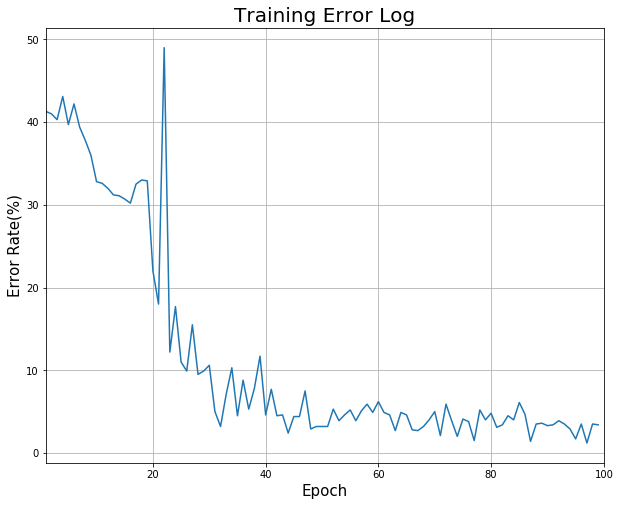

In [23]:
def plot_train_error_log(train_log):
    """
    Ploting the train_error log
    """
    plt.figure(figsize=(10,8))
    plt.plot(range(0,100), np.array(train_log)*100)
    plt.xlim(1,100)
    plt.grid()
    plt.xlabel("Epoch", size=15)
    plt.ylabel("Error Rate(%)", size=15)
    plt.title("Training Error Log", size=20)
    plt.savefig("training error log.jpg") 
    
plot_train_error_log(train_log)


# Comparison with Pytorch

In [24]:
from torch import set_grad_enabled
import torch.nn as nn
import torch.optim as optim
set_grad_enabled(True)

In [25]:
# Generate train set and test set
nb_points = 1000
train_input, train_target = generate_disk_dataset(nb_points)
test_input,test_target = generate_disk_dataset(nb_points)

In [26]:
# Normalization
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

model = nn.Sequential(nn.Linear(2,25),nn.ReLU(),nn.Linear(25,25),nn.ReLU(),nn.Linear(25,25),nn.ReLU(),nn.Linear(25,2),nn.Tanh())
epochs = 100
learning_rate = 5e-1
mini_batch_size = 50
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [27]:
train_log_torch = []
f = open("error_logs_torch.txt","w")
for e in range(epochs):
    for batch in range(0,train_input.size(0),mini_batch_size):

        f.write("\n-------------Starting epoch {}------------- : \n".format(e))
        y_pred = model(train_input.narrow(0,batch,mini_batch_size))
        loss = criterion(y_pred,train_target.narrow(0,batch,mini_batch_size).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    error = y_pred.max(1)[1].ne(train_target.narrow(0, batch, mini_batch_size).max(1)[1]).sum().item()/y_pred.size(0)
    f.write("Epoch {} Batch {} Loss {:4.2f} error {:4.2f}% \n".format(epoch,int(batch/mini_batch_size),loss,error*100))
    train_log_torch.append(error)
        
    
    
train_output_torch = model(train_input)
train_error_torch = (train_output_torch.max(1)[1].ne(train_target.max(1)[1]).sum()).item()/train_output_torch.size(0)
print("Final Train Error: {:.2%} \n".format(train_error_torch))
f.write("Final Train Error: {:.2%} \n".format(train_error_torch))

test_output_torch = model(test_input)
test_error_torch = (test_output_torch.max(1)[1].ne(test_target.max(1)[1]).sum()).item()/test_output_torch.size(0)
print("Final Test Error: {:.2%} \n".format(test_error_torch))      
f.write("Final Test Error: {:.2%} \n".format(test_error_torch))
f.close()





Final Train Error: 3.50% 

Final Test Error: 4.30% 



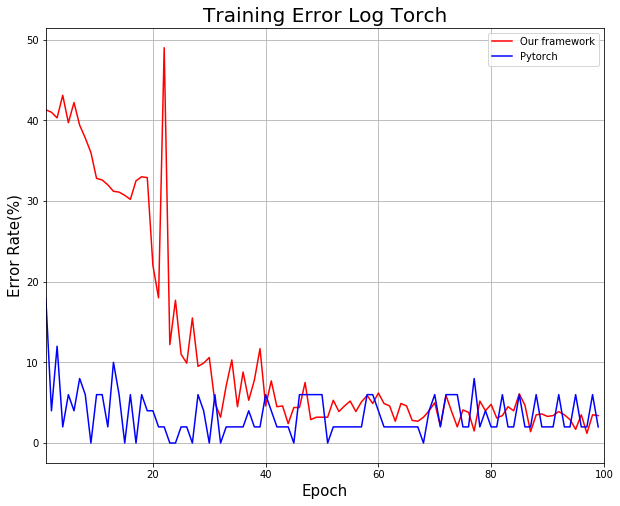

In [31]:
def plot_train_error_log_torch(train_log1,train_log2):
    """
    Ploting the train_error log
    """
    plt.figure(figsize=(10,8))
    plt.plot(range(0,100), np.array(train_log1)*100,'r',label="Our framework")
    plt.plot(range(0,100), np.array(train_log2)*100,'b',label="Pytorch")
    plt.legend(loc="upper right")
    plt.xlim(1,100)
    plt.grid()
    plt.xlabel("Epoch", size=15)
    plt.ylabel("Error Rate(%)", size=15)
    plt.title("Training Error Log Torch", size=20)
    plt.savefig("training error log Torch.jpg") 
    
plot_train_error_log_torch(train_log,train_log_torch)